- [19.3 - Hierarchical Bayesian Approach](#19.3---Hierarchical-Bayesian-Approach)
- [19.4 - Adding a Metric Predictor](#19.4---Adding-a-Metric-Predictor)

## Chapter 19 - Metric Predicted Variable with One Nominal Predictor

In [192]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import norm
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

color = '#87ceeb'

In [153]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [154]:
# Plot the posterior predictive distribution on a swarmplot
def plot_mustache(var, sd, j):
    for i in np.arange(0, len(var), int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        xrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        plt.plot(-rv.pdf(xrange)*20+j, xrange, color=color)

### 19.3 - Hierarchical Bayesian Approach

In [155]:
df = pd.read_csv('data/FruitflyDataReduced.csv')
df.CompanionNumber = df.CompanionNumber.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
Longevity          125 non-null int64
CompanionNumber    125 non-null category
Thorax             125 non-null float64
dtypes: category(1), float64(1), int64(1)
memory usage: 2.2 KB


In [4]:
df.head()

   Longevity CompanionNumber  Thorax
0         35       Pregnant8    0.64
1         37       Pregnant8    0.68
2         49       Pregnant8    0.68
3         46       Pregnant8    0.72
4         63       Pregnant8    0.72

In [7]:
df.CompanionNumber.value_counts()

Virgin8      25
Virgin1      25
Pregnant8    25
Pregnant1    25
None0        25
Name: CompanionNumber, dtype: int64

In [5]:
df.CompanionNumber.cat.categories

Index(['None0', 'Pregnant1', 'Pregnant8', 'Virgin1', 'Virgin8'], dtype='object')

In [211]:
df.CompanionNumber.cat.codes.values

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

#### Model (Kruschke, 2015)

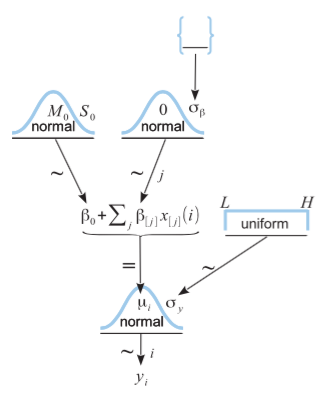

In [32]:
Image('images/fig19_2.png')

In [181]:
x = df.CompanionNumber.cat.codes.values
y = df.Longevity
yMean = y.mean()
ySD = y.std()

NxLvl = len(df.CompanionNumber.cat.categories)

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pmc.Model() as model1:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pmc.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pmc.Uniform('ySigma', ySD/100, ySD*10)
    y = pmc.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pmc.Deterministic('m', a0 + a)
    b0 = pmc.Deterministic('b0', tt.mean(m))
    b = pmc.Deterministic('b', m - b0) 

In [161]:
with model1:
    trace1 = pmc.sample(10000)

Assigned NUTS to aSigma_log_
Assigned NUTS to a0
Assigned NUTS to a
Assigned NUTS to ySigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 19.0 sec

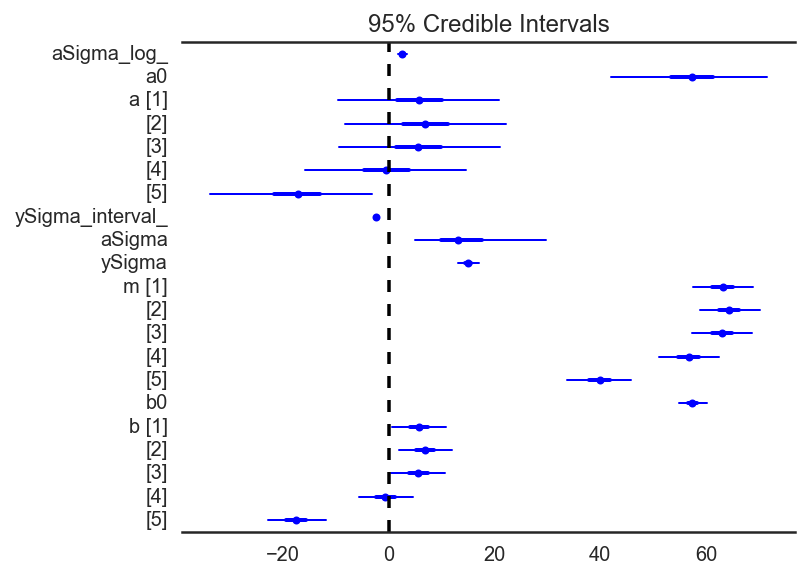

In [162]:
pmc.forestplot(trace1);

In [163]:
pmc.df_summary(trace1)

             mean        sd  mc_error    hpd_2.5   hpd_97.5
a0      57.316151  7.237593  0.185145  42.118943  71.627748
a__0     5.862161  7.592408  0.186732  -9.543554  20.869152
a__1     6.995916  7.561213  0.184416  -8.314689  22.087591
a__2     5.697229  7.558490  0.184409  -9.408345  21.048611
a__3    -0.517613  7.567165  0.182305 -15.907934  14.660336
a__4   -17.417334  7.637421  0.184834 -33.880673  -3.228232
aSigma  14.890616  7.566675  0.142557   4.876097  29.762256
ySigma  15.002667  1.374362  0.023575  13.172627  16.967110
m__0    63.178312  2.921276  0.023413  57.494901  68.928910
m__1    64.312067  2.882744  0.024115  58.904826  70.197176
m__2    63.013380  2.909354  0.025180  57.315622  68.665586
m__3    56.798538  2.929989  0.025415  51.124502  62.527507
m__4    39.898817  3.079050  0.029648  33.659926  45.830738
b0      57.440223  1.338076  0.011876  54.886941  60.108491
b__0     5.738089  2.614501  0.022085   0.540768  10.760728
b__1     6.871844  2.554150  0.021064   

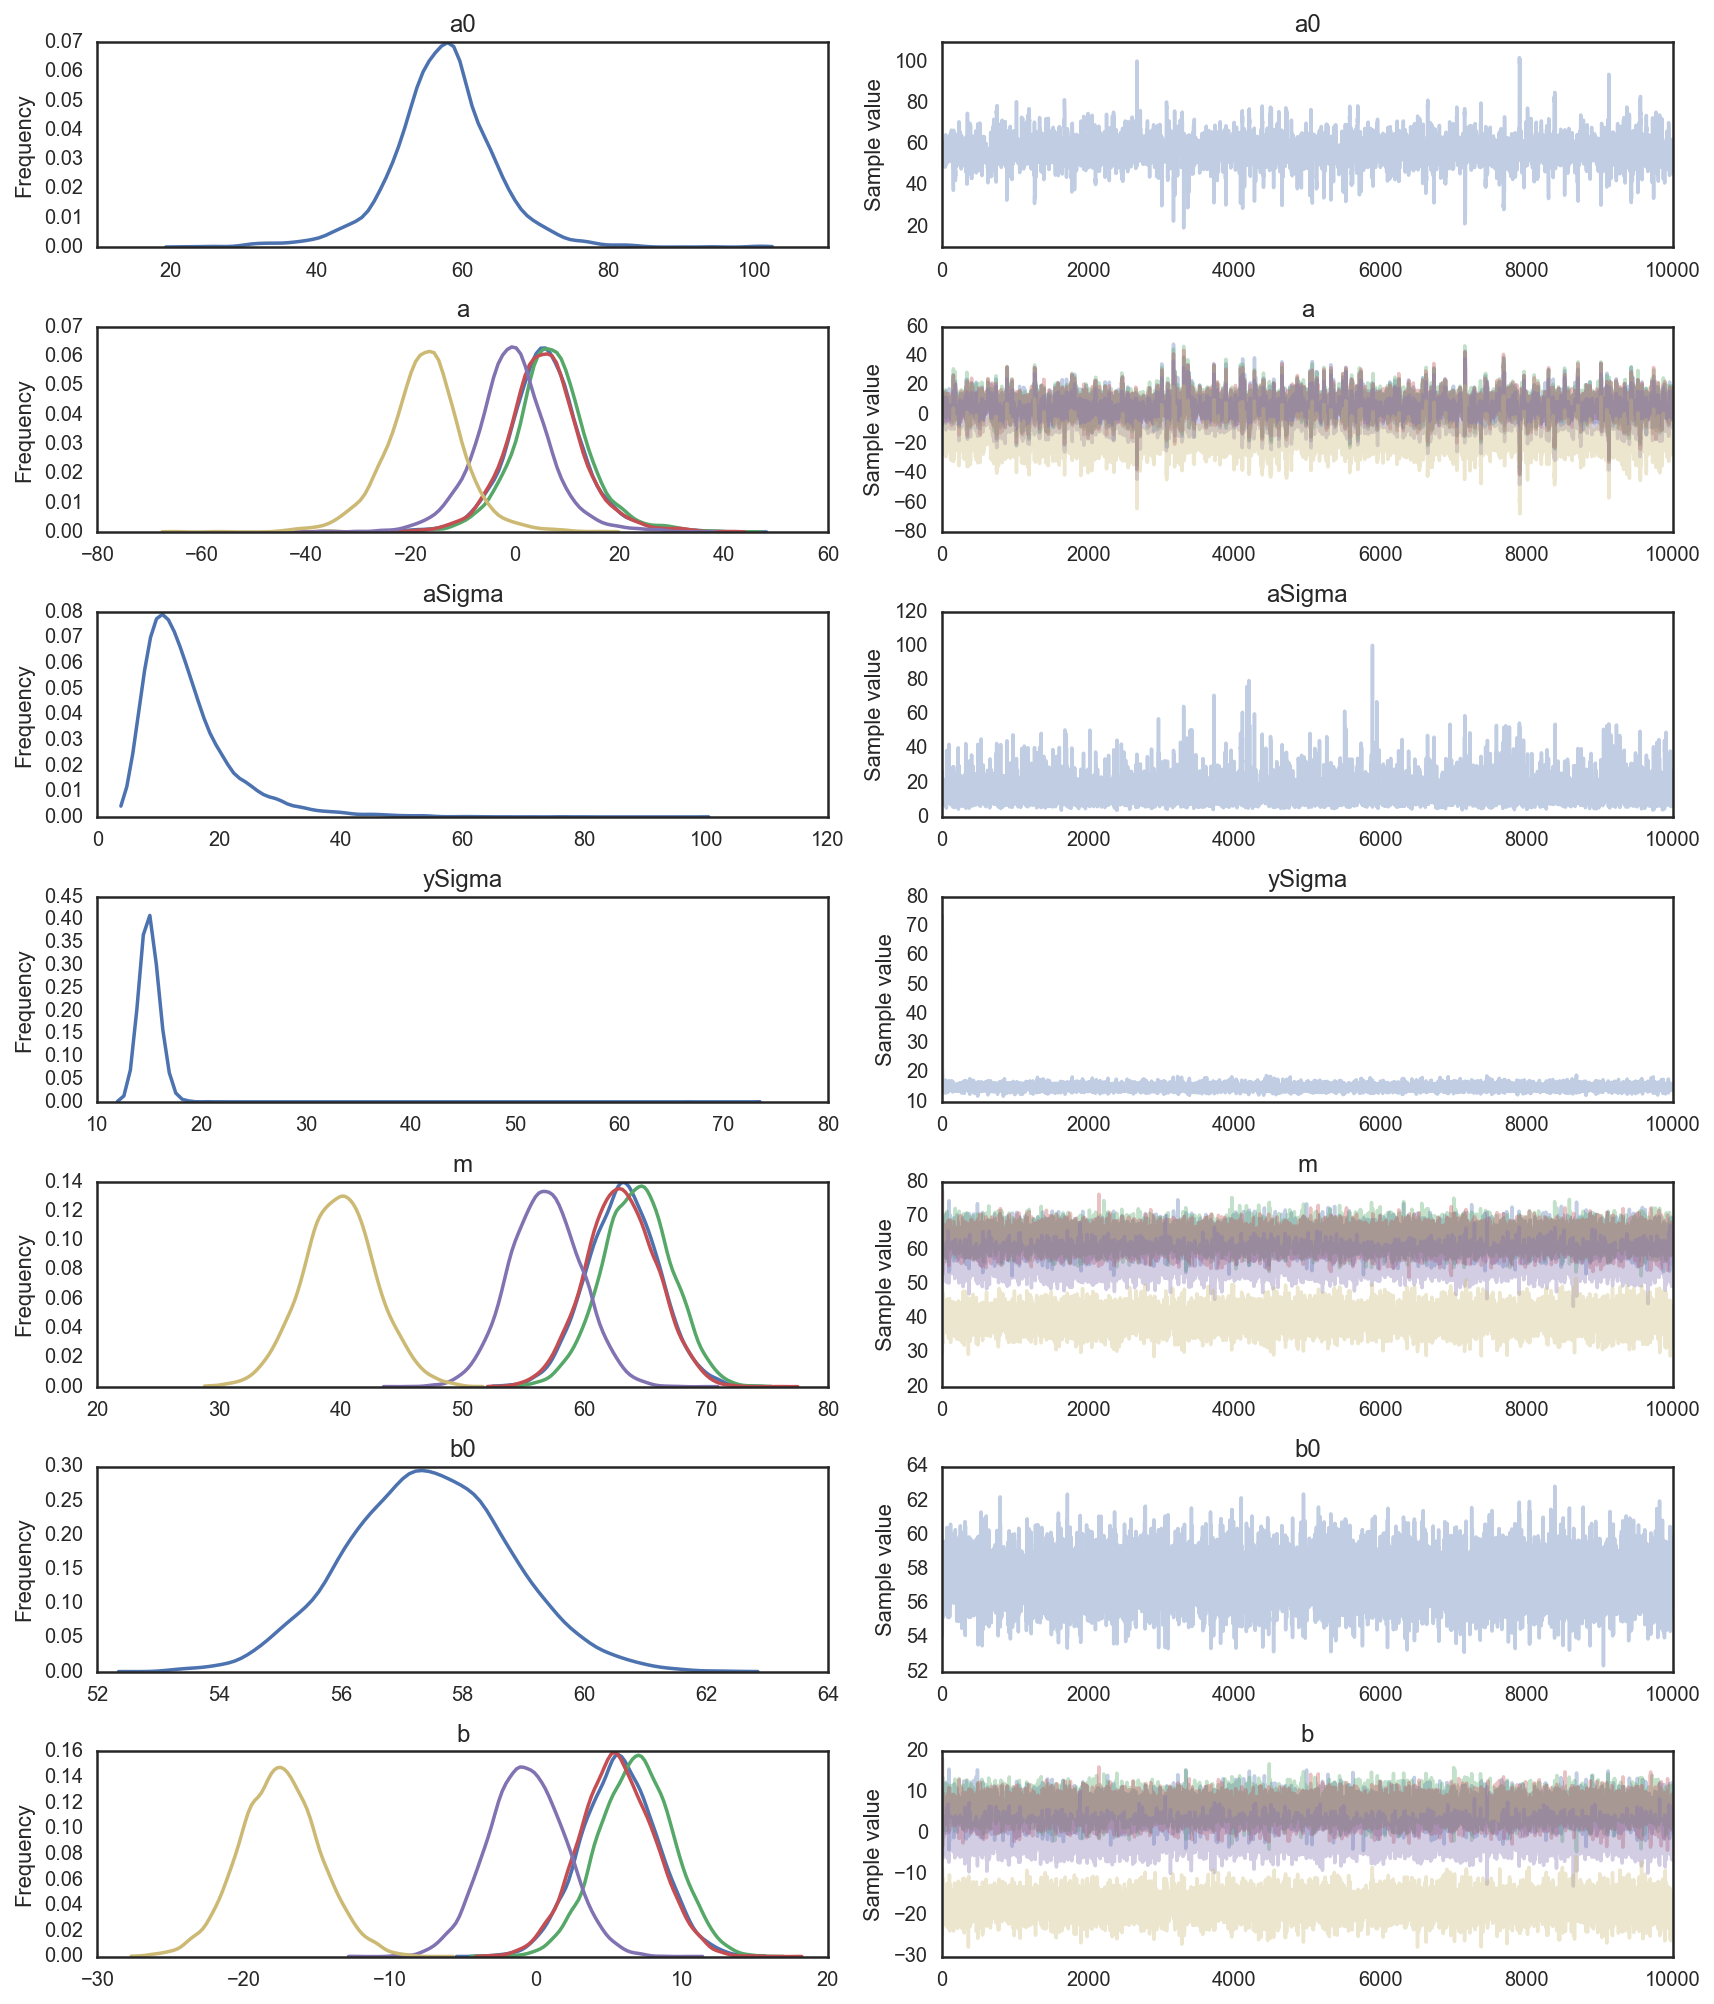

In [164]:
pmc.traceplot(trace1);

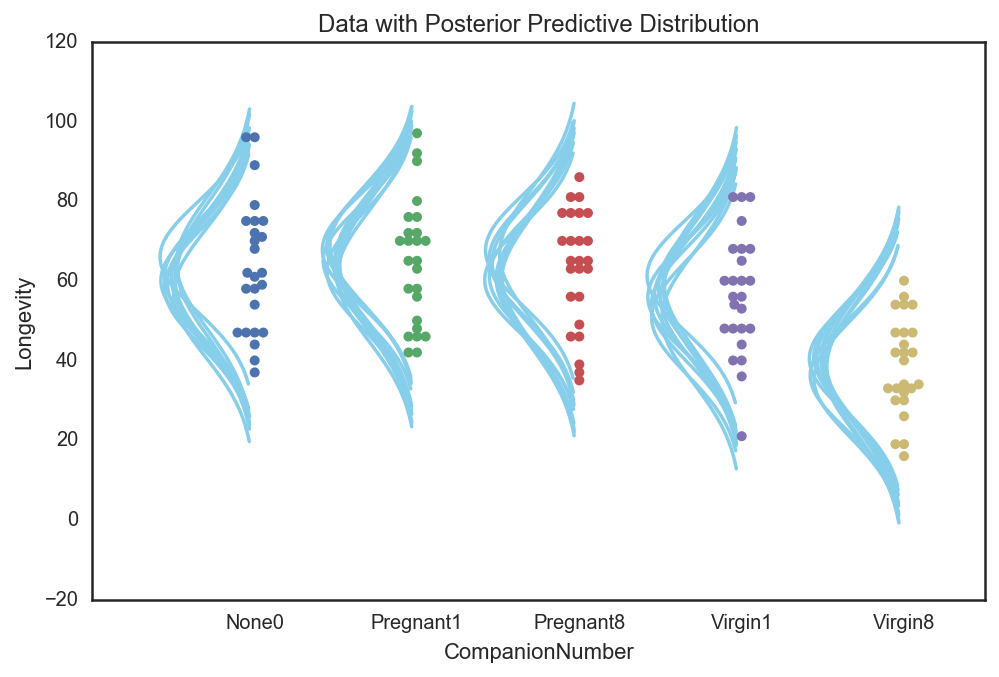

In [165]:
burnin = 200

None0 = trace1['m'][burnin:,0]
Pregnant1 = trace1['m'][burnin:,1]
Pregnant8 = trace1['m'][burnin:,2]
Virgin1 = trace1['m'][burnin:,3]
Virgin8 = trace1['m'][burnin:,4]
scale = trace1['ySigma'][burnin:]

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.set_title('Data with Posterior Predictive Distribution')

sns.swarmplot('CompanionNumber', 'Longevity', data=df, ax=ax);
ax.set_xlim(xmin=-1)

for i, grp in enumerate([None0, Pregnant1, Pregnant8, Virgin1, Virgin8]):
    plot_mustache(grp, scale, i)

#### Contrasts

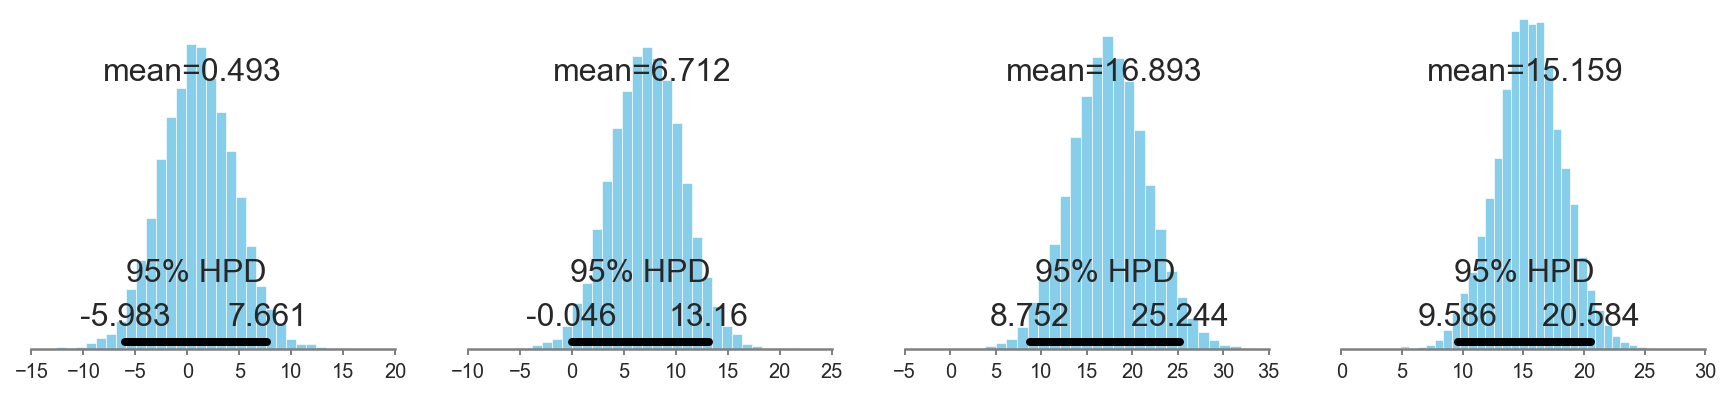

In [166]:
fig, axes = plt.subplots(1,4, figsize=(15,3))

pmc.plot_posterior(np.mean([Pregnant1, Pregnant8], axis=0)-None0, color=color, ax=axes[0])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1, color=color, ax=axes[1])
pmc.plot_posterior(Virgin1-Virgin8, color=color, ax=axes[2])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0), color=color, ax=axes[3])

### 19.4 - Adding a Metric Predictor

#### Model (Kruschke, 2015)

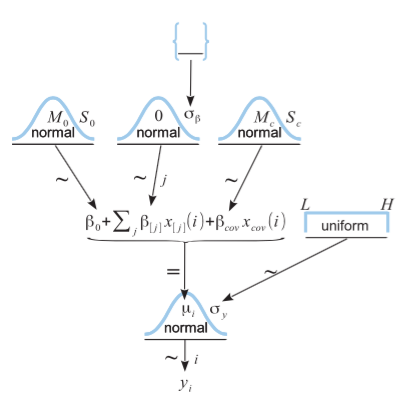

In [151]:
Image('images/fig19_4.png')

In [207]:
y = df.Longevity
yMean = y.mean()
ySD = y.std()
xNom = df.CompanionNumber.cat.categories
xMet = df.Thorax
xMetMean = df.Thorax.mean()
xMetSD = df.Thorax.std()
NxNomLvl = len(df.CompanionNumber.cat.categories)

X = pd.concat([df.Thorax, pd.get_dummies(df.CompanionNumber, drop_first=True)], axis=1)
lmInfo = LinearRegression().fit(X, y)
residSD = np.sqrt(mean_squared_error(y, lmInfo.predict(X)))

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pmc.Model() as model2:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pmc.Normal('a', 0.0, tau=1/aSigma**2, shape=NxNomLvl)
    aMet = pmc.Normal('aMet', 0, tau=1/(2*ySD/xMetSD)**2)
       
    ySigma = pmc.Uniform('ySigma', residSD/100, ySD*10)
    
    mu = a0 + a[x] + aMet*(xMet - xMetMean)
    y = pmc.Normal('y', mu, tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    b0 = pmc.Deterministic('b0', a0 + tt.mean(a) + aMet*(-xMetMean))
    b = pmc.Deterministic('b', a - tt.mean(a)) 

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied interval-transform to ySigma and added transformed ySigma_interval_ to model.


In [208]:
with model2:
    trace2 = pmc.sample(10000)

Assigned NUTS to aSigma_log_
Assigned NUTS to a0
Assigned NUTS to a
Assigned NUTS to aMet
Assigned NUTS to ySigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 29.4 sec

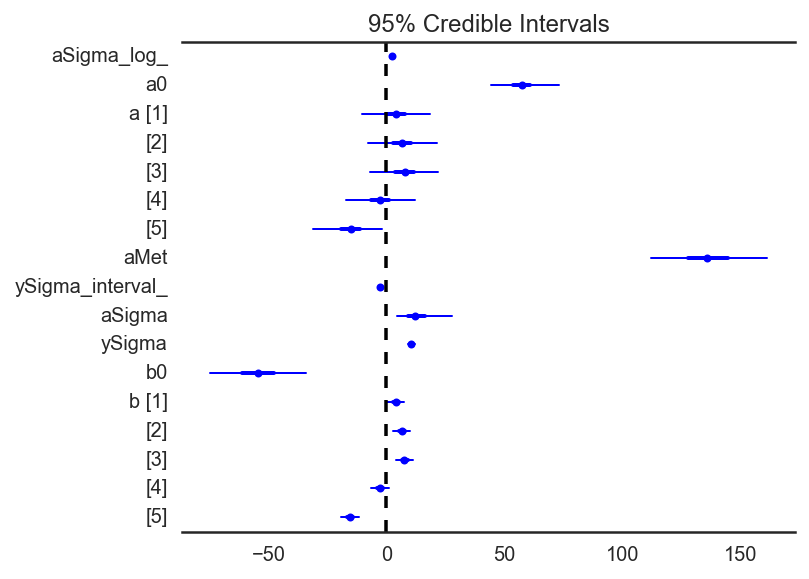

In [209]:
pmc.forestplot(trace2);

In [210]:
pmc.df_summary(trace2)

              mean         sd  mc_error     hpd_2.5    hpd_97.5
a0       57.147727   7.298829  0.223494   44.431137   73.133926
a__0      4.233075   7.480117  0.221232  -10.257594   18.692735
a__1      6.761994   7.470793  0.225055   -7.678297   21.386349
a__2      7.990143   7.447443  0.225973   -6.854493   21.886748
a__3     -2.572335   7.504444  0.219184  -17.023698   12.057807
a__4    -14.991366   7.509446  0.225218  -31.170782   -1.891357
aMet    136.132111  12.626309  0.108186  112.355629  161.496836
aSigma   14.006107   7.435886  0.182586    4.701599   27.831252
ySigma   10.640947   0.939036  0.015284    9.262102   11.989884
b0      -54.326989  10.421157  0.088576  -74.817155  -34.209861
b__0      3.948773   1.871892  0.017810    0.292284    7.527509
b__1      6.477692   1.912722  0.018096    2.746242   10.201172
b__2      7.705841   1.888845  0.016392    3.924981   11.318246
b__3     -2.856637   1.919575  0.017842   -6.427763    0.981536
b__4    -15.275668   1.995932  0.021651 

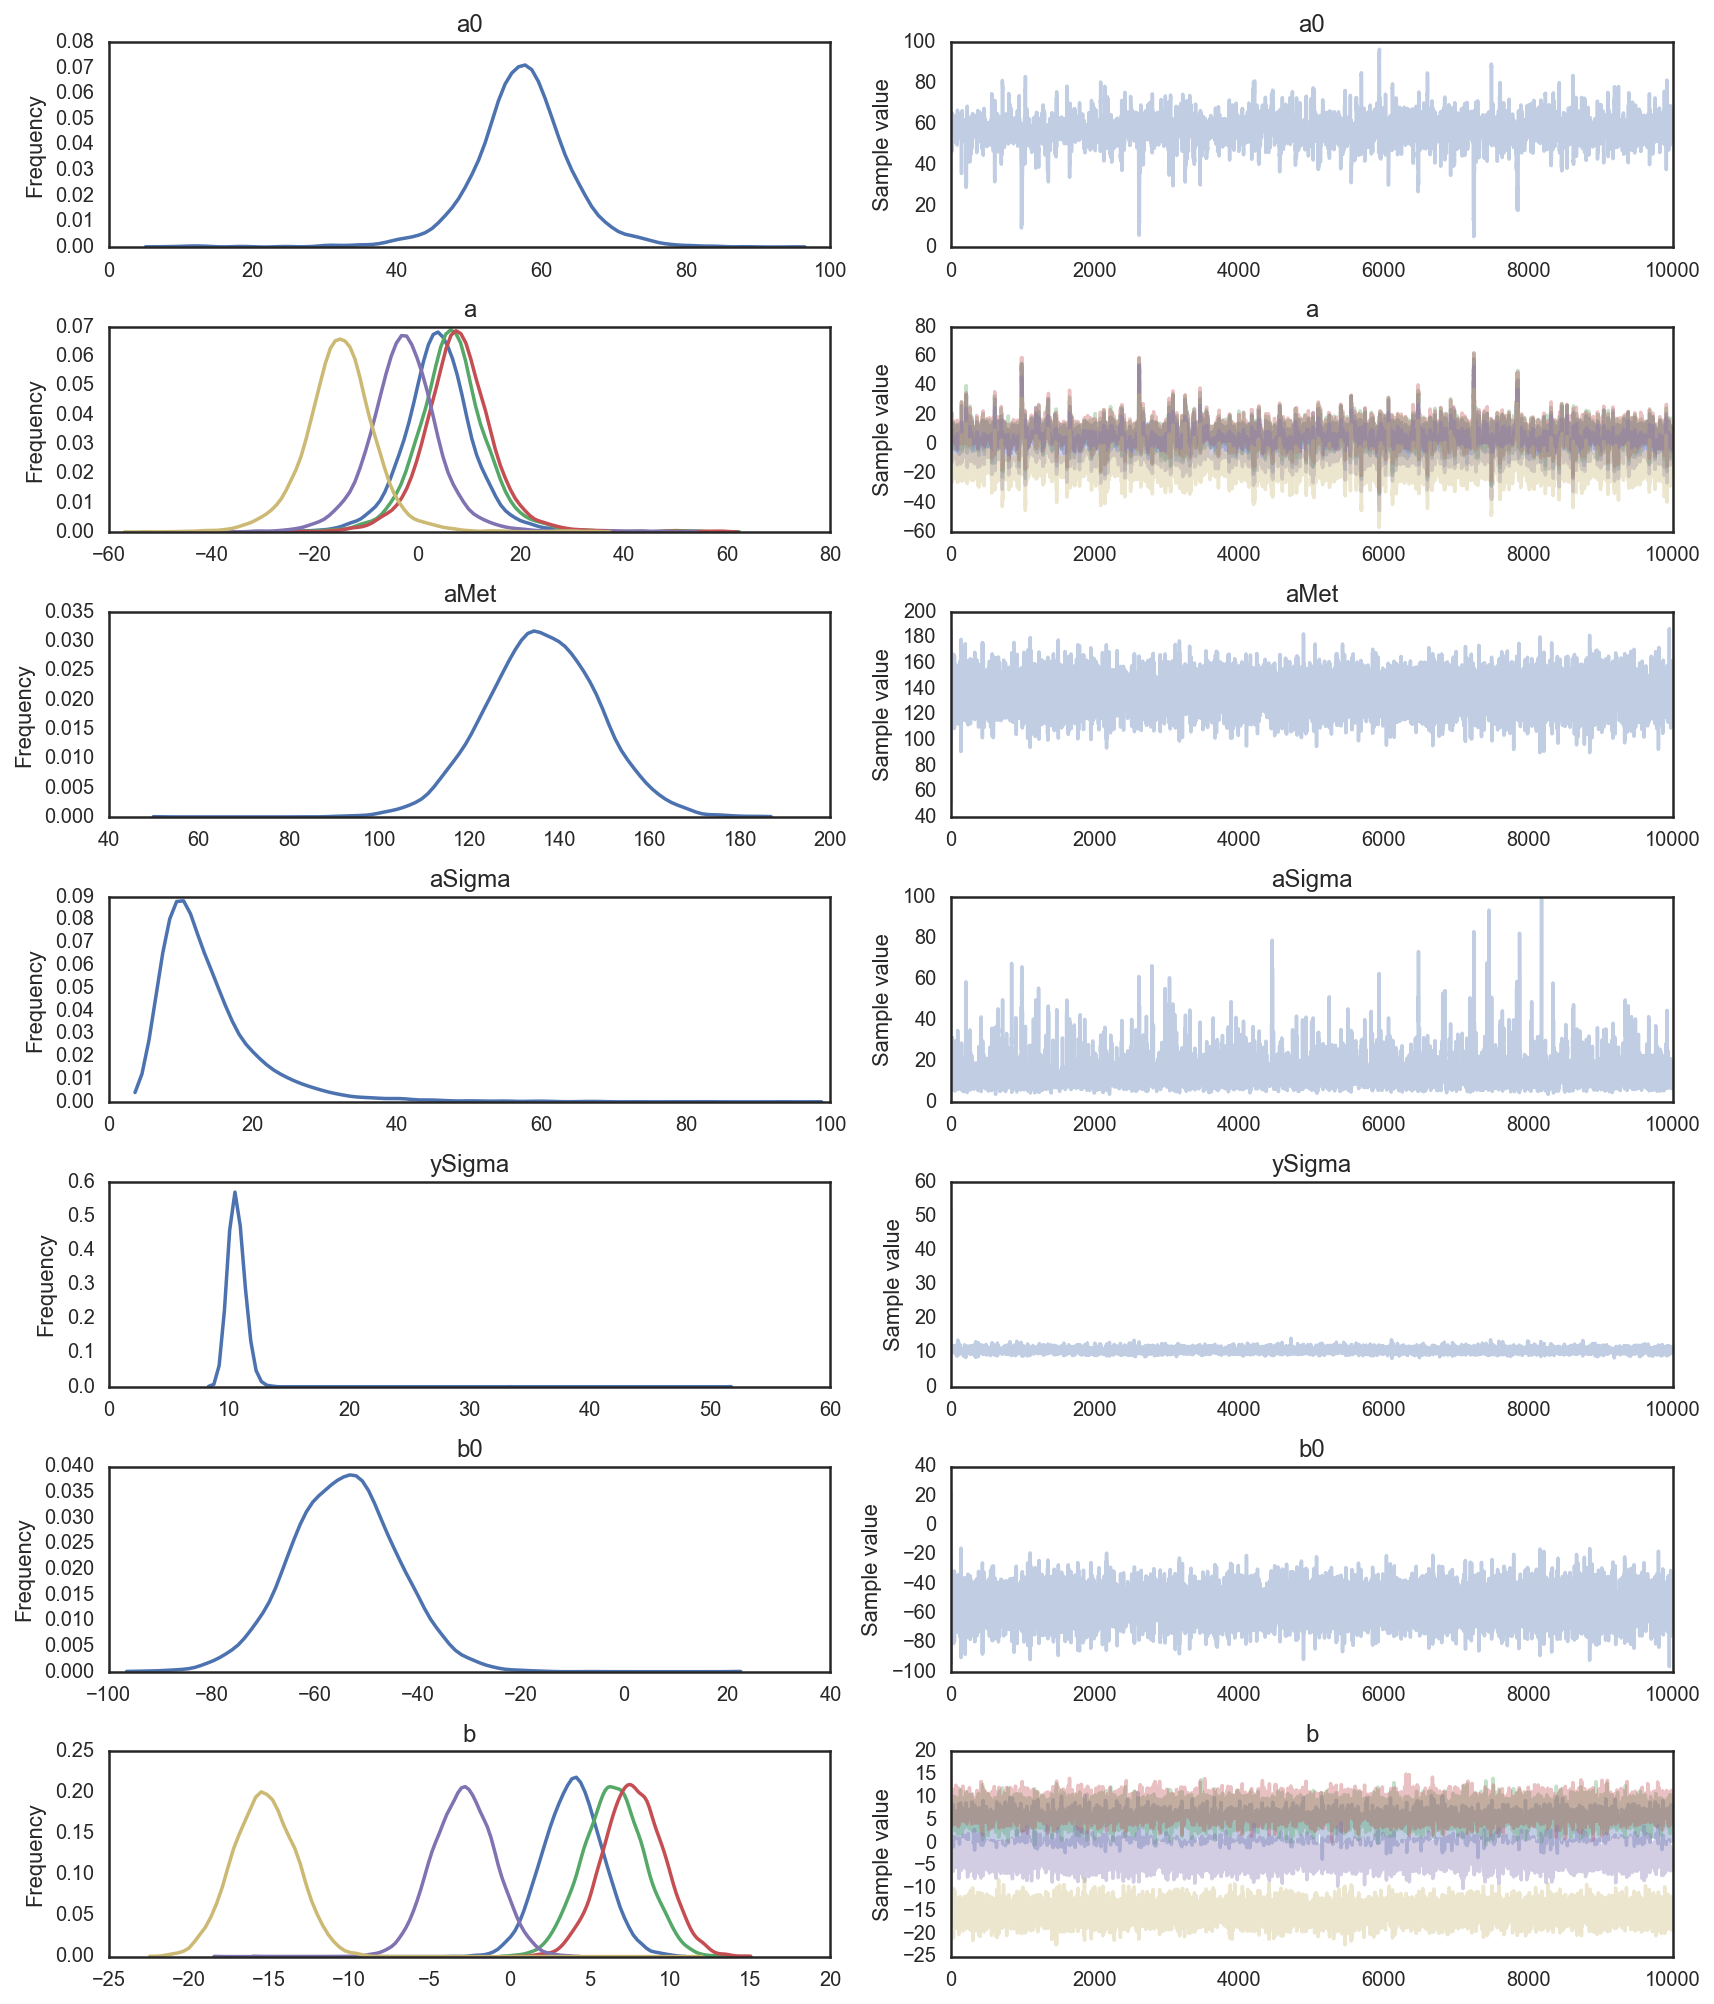

In [213]:
pmc.traceplot(trace2);

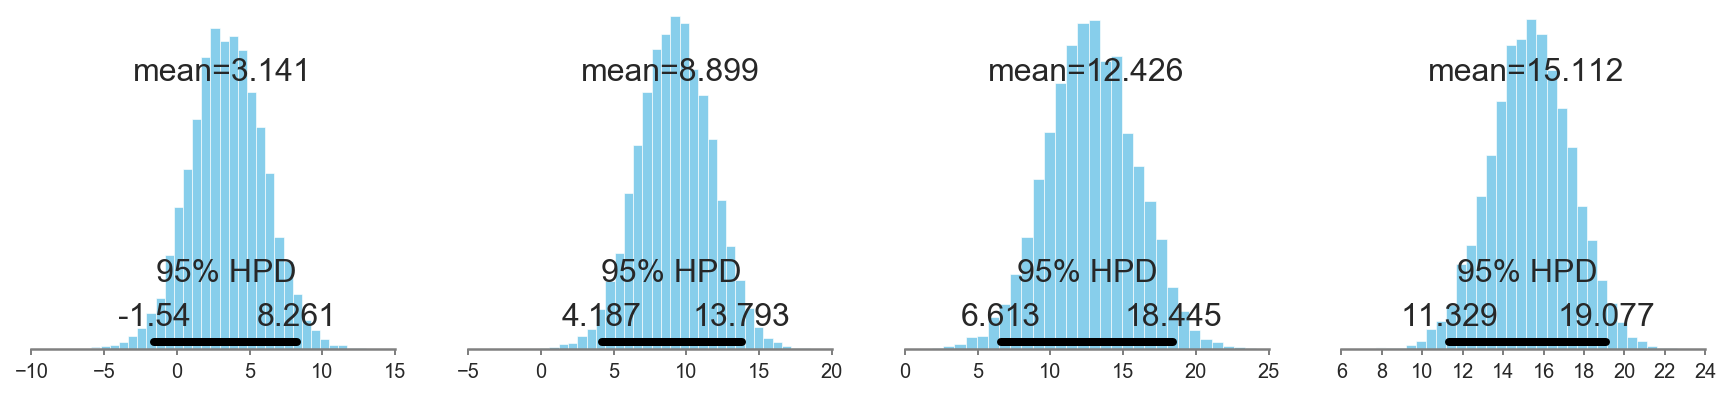

In [220]:
burnin = 200

None0 = trace2['b'][burnin:,0]
Pregnant1 = trace2['b'][burnin:,1]
Pregnant8 = trace2['b'][burnin:,2]
Virgin1 = trace2['b'][burnin:,3]
Virgin8 = trace2['b'][burnin:,4]
scale = trace2['ySigma'][burnin:]

fig, axes = plt.subplots(1,4, figsize=(15,3))

pmc.plot_posterior(np.mean([Pregnant1, Pregnant8], axis=0)-None0, color=color, ax=axes[0])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1, color=color, ax=axes[1])
pmc.plot_posterior(Virgin1-Virgin8, color=color, ax=axes[2])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0), color=color, ax=axes[3])